This notebook will be mainly used for the capstone project.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [2]:
CLIENT_ID = 'ZSTKZCQ3JJ52O4HMGJI1F44TMAKYFP5RX3HYH4YVYFQHKBQQ' # your Foursquare ID
CLIENT_SECRET = 'IGQFK3UO1KC0AWBBJW5TZAVS5SFAWG3EFJNRUIGDTARN4DEL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZSTKZCQ3JJ52O4HMGJI1F44TMAKYFP5RX3HYH4YVYFQHKBQQ
CLIENT_SECRET:IGQFK3UO1KC0AWBBJW5TZAVS5SFAWG3EFJNRUIGDTARN4DEL


In [3]:
from bs4 import BeautifulSoup
# Import required packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
!pip install geocoder

     |████████████████████████████████| 102kB 13.6MB/s ta 0:00:01


In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

res = requests.get(URL).text
soup = BeautifulSoup(res,'lxml')
table = str(soup.table)
dfs = pd.read_html(table)
df_neighbourhoods = dfs[0][dfs[0].Borough != 'Not assigned']
df_neighbourhoods = pd.DataFrame(df_neighbourhoods.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x))).reset_index()

In [21]:
df_neighbourhoods.shape
df_neighbourhoods.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In this workbook I have extracted the neighbourhood data for toronto and cleaned it up, concatenated neighbourhoods that have the same postcode and replaced neighbourhood with borough in instances where no neighbourhood name was included

the geocoder data wasnt able to be pulled so I used the csv file

In [22]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.rename(columns={'Postal Code':'Postcode'},inplace=True)
df_neighbourhoods = pd.merge(df_neighbourhoods,lat_lon,on='Postcode')
df_neighbourhoods.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [23]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_neighbourhoods['Latitude'], df_neighbourhoods['Longitude'], df_neighbourhoods['Borough'], df_neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [24]:
def getNearbyVenues(name, lat, lng, radius=500):
    
    venues_list=[]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}'.format(
    CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, "", radius)


            
        # make the GET request
    results = requests.get(url).json()['response']['venues']
   
        # return only relevant information for each nearby venue
    for v in results:
        if len(v['categories']) == 0:
            continue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['shortName']) ])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
toronto_venues = list()
print(df_neighbourhoods.head())
for index, row in df_neighbourhoods.iterrows():
    print(row)
    print(row["Neighbourhood"])
    toronto_venues.append(getNearbyVenues(row['Neighbourhood'],
                                   row['Latitude'],
                                   row['Longitude']
                                  ))

  Postcode      Borough                           Neighbourhood   Latitude  \
0      M1B  Scarborough                          Rouge, Malvern  43.806686   
1      M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2      M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3      M1G  Scarborough                                  Woburn  43.770992   
4      M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476  
Postcode                    M1B
Borough             Scarborough
Neighbourhood    Rouge, Malvern
Latitude                43.8067
Longitude              -79.1944
Name: 0, dtype: object
Rouge, Malvern
Postcode                                            M1C
Borough                                     Scarborough
Neighbourhood    Highland Creek, Rouge Hill, Port Union
Latitude                                        43.7845
Longitude          

In [26]:
df_toronto_venues = pd.concat(toronto_venues)

print(df_toronto_venues.shape)
df_toronto_venues.head()

(2660, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
1,"Rouge, Malvern",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
2,"Rouge, Malvern",43.806686,-79.194353,Allied Technical Services,43.807999,-79.198802,Office
3,"Rouge, Malvern",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
4,"Rouge, Malvern",43.806686,-79.194353,Tim Hortons,43.802000,-79.198169,Coffee Shop


In [27]:
df_toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",30,30,30,30,30,30
Agincourt,27,27,27,27,27,27
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",24,24,24,24,24,24
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",29,29,29,29,29,29
"Alderwood, Long Branch",30,30,30,30,30,30
"Bathurst Manor, Downsview North, Wilson Heights",29,29,29,29,29,29
Bayview Village,24,24,24,24,24,24
"Bedford Park, Lawrence Manor East",30,30,30,30,30,30
Berczy Park,29,29,29,29,29,29


In [28]:
# one hot encoding
toronto_onehot = pd.get_dummies(df_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = df_toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,ATM,Academic Building,Accessories,Administrative Building,Adult Boutique,Advertising Agency,Afghan,African,Airport,Airport Service,Alternative Healer,American,Antiques,Apparel,Arcade,Argentinian,Art Gallery,Art Studio,Arts,Arts & Crafts,Arts & Entertainment,Asian,Assisted Living,Athletics & Sports,Auditorium,Auto Dealer,Auto Garage,Auto Workshop,Automotive,B & B,BBQ,Badminton Court,Bagels,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Belgian,Big Box Store,Bike,Bike Shop,Bike Trail,Billiards,Bistro,Board Shop,Boat / Ferry,Bookstore,Boutique,Bowling Alley,Breakfast,Brewery,Bridal,Bridge,Bubble Tea,Buffet,Building,Burgers,Burmese,Burritos,Bus,Bus Station,Bus Stop,Business Services,Butcher,Cafeteria,Café,Cajun / Creole,Cambodian,Candy Store,Cantonese,Capitol Building,Car Washes,Caribbean,Cemetery,Cheese Shop,Chinese,Chinese Breakfast,Church,City Hall,Classroom,Cocktail,Coffee Shop,Comedy Club,Comfort Food,Comic Shop,Communications,Community Center,Concert Hall,Conference room,Construction,Convenience Store,Convention Center,Cosmetics,Courthouse,Coworking Space,Creperie,Cultural Center,Cupcakes,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design,Desserts,Dim Sum,Diner,Discount Store,Dispensary,Dive Bar,Doctor's Office,Dog Run,Donuts,Dry Cleaner,Dumplings,Eastern European,Education,Electronics,Elementary School,Embassy,Emergency Room,Engineering,Entertainment,Entertainment Service,Ethiopian,Event Space,Fabric Shop,Factory,Falafel,Farm,Farmer's Market,Fast Food,Festival,Field,Filipino,Financial / Legal,Fire Station,Fireworks Store,Fish & Chips,Flight School,Flower Shop,Food,Food & Drink,Food Court,Food Service,Food Stand,Food Truck,French,Fried Chicken,Fruit & Vegetable Store,Funeral Home,Furniture / Home,Garden,Garden Center,Gas Station,Gastropub,Gate,German,Gift Shop,Golf Course,Golf Driving Range,Government,Greek,Grocery Store,Gym,Gym / Fitness,Hakka,Halal,Harbor / Marina,Hardware,Health & Beauty,Health Food Store,Herbs & Spices Store,High School,Hindu Temple,Historic Site,History Museum,Hobbies,Hockey,Hookah Bar,Hospital,Hostel,Hot Dogs,Hotel,Housing Development,Hungarian,Ice Cream,Indian,Indie Movies,Intersection,Irish,Italian,Japanese,Jewelry,Jewish,Juice Bar,Karaoke,Kebab,Kids Store,Kingdom Hall,Korean,Lake,Landmark,Latin American,Laundromat,Laundry,Library,Light Rail,Liquor Store,Lounge,Mac & Cheese,Mall,Market,Martial Arts,Massage Studio,Medical,Medical Lab,Medical School,Medical Supply,Mediterranean,Men's Store,Metro,Mexican,Middle Eastern,Middle School,Mobile Phones,Moroccan,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,New American,Nightclub,Nightlife,Noodles,Nursery School,Office,Office Supplies,Opera House,Optical,Organic Grocery,Other Event,Other Outdoors,Other Repair,Pakistani,Park,Parking,Pastry,Performing Arts,Persian,Pet Service,Pet Store,Pharmacy,Photography Lab,Physical Therapist,Piano Bar,Pizza,Playground,Plaza,Police Station,Pool,Portuguese,Post Office,Poutine Place,Prayer Room,Print Shop,Professional,Pub,Quad,Racetrack,Ramen,Real Estate,Record Shop,Recording Studio,Recreation Center,Rental Car,Residence Hall,Residential,Rest Areas,Restaurant,River,Rock Climbing,Rock Club,Roof Deck,Sake Bar,Salad,Salon / Barbershop,Sandwiches,Scenic Lookout,School,Science,Sculpture,Seafood,Shanghai,Shawarma Place,Shipping Store,Shoe Repair,Shoes,Shop,Shopping Plaza,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Snacks,Social Club,Soup,South Indian,Spa,Spanish,Speakeasy,Spiritual,Sporting Goods,Sports Bar,Sri Lankan,Stationery Store,Steakhouse,Storage,Street Art,Strip Club,Student Center,Supermarket,Supplement Shop,Surf Spot,Sushi,Swiss,Synagogue,Tacos,Tanning Salon,Tapas,Tattoo,Tea Room,Tech Startup,Tennis Court,Thai,Theater,Theme Park,Thrift / Vintage,Tibetan,Tourist Information,Toys & Games,Track,Trade School,Trail,Trailer Park,Train Station,Transportation Services,Travel,Tr

In [30]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,ATM,Academic Building,Accessories,Administrative Building,Adult Boutique,Advertising Agency,Afghan,African,Airport,Airport Service,Alternative Healer,American,Antiques,Apparel,Arcade,Argentinian,Art Gallery,Art Studio,Arts,Arts & Crafts,Arts & Entertainment,Asian,Assisted Living,Athletics & Sports,Auditorium,Auto Dealer,Auto Garage,Auto Workshop,Automotive,B & B,BBQ,Badminton Court,Bagels,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Belgian,Big Box Store,Bike,Bike Shop,Bike Trail,Billiards,Bistro,Board Shop,Boat / Ferry,Bookstore,Boutique,Bowling Alley,Breakfast,Brewery,Bridal,Bridge,Bubble Tea,Buffet,Building,Burgers,Burmese,Burritos,Bus,Bus Station,Bus Stop,Business Services,Butcher,Cafeteria,Café,Cajun / Creole,Cambodian,Candy Store,Cantonese,Capitol Building,Car Washes,Caribbean,Cemetery,Cheese Shop,Chinese,Chinese Breakfast,Church,City Hall,Classroom,Cocktail,Coffee Shop,Comedy Club,Comfort Food,Comic Shop,Communications,Community Center,Concert Hall,Conference room,Construction,Convenience Store,Convention Center,Cosmetics,Courthouse,Coworking Space,Creperie,Cultural Center,Cupcakes,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design,Desserts,Dim Sum,Diner,Discount Store,Dispensary,Dive Bar,Doctor's Office,Dog Run,Donuts,Dry Cleaner,Dumplings,Eastern European,Education,Electronics,Elementary School,Embassy,Emergency Room,Engineering,Entertainment,Entertainment Service,Ethiopian,Event Space,Fabric Shop,Factory,Falafel,Farm,Farmer's Market,Fast Food,Festival,Field,Filipino,Financial / Legal,Fire Station,Fireworks Store,Fish & Chips,Flight School,Flower Shop,Food,Food & Drink,Food Court,Food Service,Food Stand,Food Truck,French,Fried Chicken,Fruit & Vegetable Store,Funeral Home,Furniture / Home,Garden,Garden Center,Gas Station,Gastropub,Gate,German,Gift Shop,Golf Course,Golf Driving Range,Government,Greek,Grocery Store,Gym,Gym / Fitness,Hakka,Halal,Harbor / Marina,Hardware,Health & Beauty,Health Food Store,Herbs & Spices Store,High School,Hindu Temple,Historic Site,History Museum,Hobbies,Hockey,Hookah Bar,Hospital,Hostel,Hot Dogs,Hotel,Housing Development,Hungarian,Ice Cream,Indian,Indie Movies,Intersection,Irish,Italian,Japanese,Jewelry,Jewish,Juice Bar,Karaoke,Kebab,Kids Store,Kingdom Hall,Korean,Lake,Landmark,Latin American,Laundromat,Laundry,Library,Light Rail,Liquor Store,Lounge,Mac & Cheese,Mall,Market,Martial Arts,Massage Studio,Medical,Medical Lab,Medical School,Medical Supply,Mediterranean,Men's Store,Metro,Mexican,Middle Eastern,Middle School,Mobile Phones,Moroccan,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,New American,Nightclub,Nightlife,Noodles,Nursery School,Office,Office Supplies,Opera House,Optical,Organic Grocery,Other Event,Other Outdoors,Other Repair,Pakistani,Park,Parking,Pastry,Performing Arts,Persian,Pet Service,Pet Store,Pharmacy,Photography Lab,Physical Therapist,Piano Bar,Pizza,Playground,Plaza,Police Station,Pool,Portuguese,Post Office,Poutine Place,Prayer Room,Print Shop,Professional,Pub,Quad,Racetrack,Ramen,Real Estate,Record Shop,Recording Studio,Recreation Center,Rental Car,Residence Hall,Residential,Rest Areas,Restaurant,River,Rock Climbing,Rock Club,Roof Deck,Sake Bar,Salad,Salon / Barbershop,Sandwiches,Scenic Lookout,School,Science,Sculpture,Seafood,Shanghai,Shawarma Place,Shipping Store,Shoe Repair,Shoes,Shop,Shopping Plaza,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Snacks,Social Club,Soup,South Indian,Spa,Spanish,Speakeasy,Spiritual,Sporting Goods,Sports Bar,Sri Lankan,Stationery Store,Steakhouse,Storage,Street Art,Strip Club,Student Center,Supermarket,Supplement Shop,Surf Spot,Sushi,Swiss,Synagogue,Tacos,Tanning Salon,Tapas,Tattoo,Tea Room,Tech Startup,Tennis Court,Thai,Theater,Theme Park,Thrift / Vintage,Tibetan,Tourist Information,Toys & Games,Track,Trade School,Trail,Trailer Park,Train Station,Transportation Services,Travel,Tr

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Italian,Food Court,Coffee Shop,Ballroom,Hotel,Greek,Lounge,Fried Chicken,BBQ,Opera House
1,Agincourt,Event Space,Gas Station,Hardware,Latin American,Sushi,Korean,Auto Dealer,Breakfast,Automotive,Badminton Court
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese,Park,Doctor's Office,Asian,Church,Strip Club,Spa,Entertainment,Food Court,Bus
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Movie Theater,Pizza,Caribbean,Pharmacy,Grocery Store,Financial / Legal,Farm,Mediterranean,Discount Store,Art Gallery
4,"Alderwood, Long Branch",Convenience Store,Pizza,Gas Station,Asian,Pool,Chinese,Bistro,Burmese,New American,Office


In [32]:
cols = list()
for col in neighborhoods_venues_sorted.columns:
    if col == "Neighborhood":
        continue
    cols.append(col)
neighborhoods_venues_sorted_tmp = neighborhoods_venues_sorted
print(cols)
for col in cols:
    dummies = pd.get_dummies(neighborhoods_venues_sorted_tmp[col], prefix=col)
    neighborhoods_venues_sorted_tmp = pd.concat([neighborhoods_venues_sorted_tmp, dummies], axis=1)
    neighborhoods_venues_sorted_tmp.drop(col, axis=1, inplace=True)
neighborhoods_venues_sorted_tmp.head()

['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']


,Neighborhood,1st Most Common Venue_Apparel,1st Most Common Venue_Automotive,1st Most Common Venue_Bank,1st Most Common Venue_Bar,1st Most Common Venue_Building,1st Most Common Venue_Bus,1st Most Common Venue_Café,1st Most Common Venue_Caribbean,1st Most Common Venue_Chinese,1st Most Common Venue_Church,1st Most Common Venue_Coffee Shop,1st Most Common Venue_Convenience Store,1st Most Common Venue_Courthouse,1st Most Common Venue_Dog Run,1st Most Common Venue_Electronics,1st Most Common Venue_Entertainment,1st Most Common Venue_Event Space,1st Most Common Venue_Fast Food,1st Most Common Venue_Financial / Legal,1st Most Common Venue_French,1st Most Common Venue_Gate,1st Most Common Venue_Government,1st Most Common Venue_Greek,1st Most Common Venue_Grocery Store,1st Most Common Venue_High School,1st Most Common Venue_Hockey,1st Most Common Venue_Hospital,1st Most Common Venue_Hotel,1st Most Common Venue_Indian,1st Most Common Venue_Italian,1st Most Common Venue_Japanese,1st Most Common Venue_Korean,1st Most Common Venue_Light Rail,1st Most Common Venue_Mall,1st Most Common Venue_Metro,1st Most Common Venue_Middle Eastern,1st Most Common Venue_Movie Theater,1st Most Common Venue_Music Venue,1st Most Common Venue_Office,1st Most Common Venue_Park,1st Most Common Venue_Pizza,1st Most Common Venue_Playground,1st Most Common Venue_Residence Hall,1st Most Common Venue_Residential,1st Most Common Venue_Salon / Barbershop,1st Most Common Venue_Spa,1st Most Common Venue_Sushi,1st Most Common Venue_Thrift / Vintage,1st Most Common Venue_Vietnamese,2nd Most Common Venue_Academic Building,2nd Most Common Venue_Asian,2nd Most Common Venue_Auto Garage,2nd Most Common Venue_Bakery,2nd Most Common Venue_Bank,2nd Most Common Venue_Bar,2nd Most Common Venue_Breakfast,2nd Most Common Venue_Building,2nd Most Common Venue_Bus,2nd Most Common Venue_Café,2nd Most Common Venue_Caribbean,2nd Most Common Venue_Chinese,2nd Most Common Venue_Church,2nd Most Common Venue_Coffee Shop,2nd Most Common Venue_Convenience Store,2nd Most Common Venue_Donuts,2nd Most Common Venue_Education,2nd Most Common Venue_Event Space,2nd Most Common Venue_Farm,2nd Most Common Venue_Fast Food,2nd Most Common Venue_Financial / Legal,2nd Most Common Venue_Food Court,2nd Most Common Venue_Fried Chicken,2nd Most Common Venue_Furniture / Home,2nd Most Common Venue_Gas Station,2nd Most Common Venue_Government,2nd Most Common Venue_Grocery Store,2nd Most Common Venue_High School,2nd Most Common Venue_Hotel,2nd Most Common Venue_Ice Cream,2nd Most Common Venue_Indie Movies,2nd Most Common Venue_Italian,2nd Most Common Venue_Japanese,2nd Most Common Venue_Korean,2nd Most Common Venue_Mediterranean,2nd Most Common Venue_Moving Target,2nd Most Common Venue_Office,2nd Most Common Venue_Park,2nd Most Common Venue_Pharmacy,2nd Most Common Venue_Pizza,2nd Most Common Venue_Playground,2nd Most Common Venue_Post Office,2nd Most Common Venue_Quad,2nd Most Common Venue_Residential,2nd Most Common Venue_Restaurant,2nd Most Common Venue_Sandwiches,2nd Most Common Venue_Scenic Lookout,2nd Most Common Venue_School,2nd Most Common Venue_Shop,2nd Most Common Venue_Skating Rink,2nd Most Common Venue_Spa,2nd Most Common Venue_Sporting Goods,2nd Most Common Venue_Sports Bar,2nd Most Common Venue_Sushi,2nd Most Common Venue_Synagogue,2nd Most Common Venue_Trade School,2nd Most Common Venue_Veterinarians,2nd Most Common Venue_Vietnamese,2nd Most Common Venue_Women's Store,3rd Most Common Venue_ATM,3rd Most Common Venue_Asian,3rd Most Common Venue_Bank,3rd Most Common Venue_Bar,3rd Most Common Venue_Burgers,3rd Most Common Venue_Café,3rd Most Common Venue_Cajun / Creole,3rd Most Common Venue_Capitol Building,3rd Most Common Venue_Car Washes,3rd Most Common Venue_Caribbean,3rd Most Common Venue_Chinese,3rd Most Common Venue_Church,3rd Most Common Venue_Coffee Shop,3rd Most Common Venue_Convention Center,3rd Most Common Venue_Cosmetics,3rd Most Common Venue_Coworking Space,3rd Most Common Venue_Cupcakes,3rd M

In [33]:
toronto_features = neighborhoods_venues_sorted_tmp.drop("Neighborhood", axis=1)
ss_toronto = StandardScaler()
ss_toronto.fit(toronto_features)
ss_data_transformed = ss_toronto.transform(toronto_features)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.


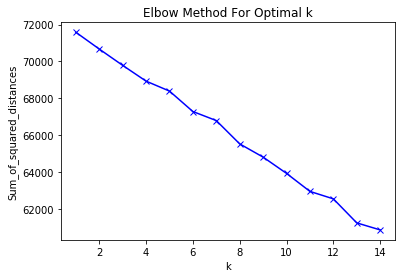

In [34]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ss_data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

from the above we set the optinmal number of k to 7 as that is where the elbow was.

In [37]:
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 2, 1, 3, 3, 3, 0, 5, 3], dtype=int32)

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_neighbourhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2,Fast Food,Caribbean,Coworking Space,Mall,Gas Station,Automotive,BBQ,Lounge,Elementary School,Chinese
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,3,Bar,Chinese,Italian,Tanning Salon,Office,Church,Salon / Barbershop,Japanese,German,Entertainment
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,3,Electronics,Bank,Restaurant,Bus,Salon / Barbershop,Church,Funeral Home,Laundry,Thrift / Vintage,Auto Dealer
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,Indian,Pharmacy,Office,Chinese,Korean,Grocery Store,Building,Nightlife,Mexican,Coffee Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Building,Caribbean,Financial / Legal,Gym,Spa,Burgers,Skating Rink,Office,Medical,Bank


In [157]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [159]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,North York,0,Apparel,Furniture / Home,Hot Dogs,Design,Office,Entertainment,Sports Bar,Event Space,Shops,Skating Rink
6,Scarborough,0,Factory,Building,Office,Automotive,Coffee Shop,Zoo Exhibit,Residential,Storage,Fried Chicken,Bank
7,North York,0,Office,Veterinarians,Tennis Court,Sandwiches,Baseball Field,Basketball Court,Athletics & Sports,Gym,Trade School,Art Studio
12,Scarborough,0,Medical,Entertainment,Bar,Office,Playground,Tanning Salon,Church,Assisted Living,Lab,Middle Eastern
13,North York,0,Office,Sporting Goods,Automotive,Restaurant,Coffee Shop,Café,Salon / Barbershop,Fast Food,Other Outdoors,Chinese
24,Downtown Toronto,0,Hospital,Coffee Shop,Emergency Room,Hospital Ward,Food Court,Medical,Sandwiches,Bagels,Café,Office
25,Downtown Toronto,0,Grocery Store,Laundry,Café,Automotive,Bakery,Gas Station,Flower Shop,Moving Target,Entertainment Service,Nightclub
26,Scarborough,0,Bakery,Building,Park,Medical,Gas Station,Thai,Athletics & Sports,Asian,Gym,Chinese
30,Downtown Toronto,0,Hotel Bar,Café,Bar,Hotel,Italian,Thai,Bagels,Bakery,Tacos,Ballroom
33,North York,0,Apparel,Shoes,Ice Cream,Coffee Shop,Library,Bank,Lingerie,Liquor Store,Electronics,Theater


In [160]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,York,1,Residential,Playground,Basketball Court,Office,Dog Run,Garden,Shoes,Gym,Trail,Park
19,East Toronto,1,Spa,Playground,Pub,Residential,Construction,School,Butcher,Lounge,Other Outdoors,Martial Arts
62,Central Toronto,1,Spa,Dentist's Office,Farmer's Market,Desserts,Gastropub,High School,Assisted Living,Italian,Office,Real Estate
78,Scarborough,1,Spa,Print Shop,Hardware,Automotive,Sandwiches,Non-Profit,Latin American,Restaurant,Government,Bar
83,Central Toronto,1,Park,Playground,Office,Church,Other Outdoors,Residential,Rest Areas,Tech Startup,School,Gym


In [161]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Downtown Toronto,2,Residential,Office,Building,Parking,Park,Bus Station,Liquor Store,Lounge,Food Truck,Student Center
36,Downtown Toronto,2,Residential,Indian,Billiards,Middle Eastern,Gastropub,Light Rail,Bank,Fried Chicken,Bike,Sports Bar
43,West Toronto,2,Residential,Office,Tech Startup,Building,Spa,Bus Stop,Art Gallery,Beer Garden,Dentist's Office,Japanese
66,North York,2,Residential,Medical,Bus,Arcade,Dentist's Office,Temple,Dog Run,Government,Chinese,Gym
67,Central Toronto,2,Residential,Convenience Store,Strip Club,Dog Run,Dentist's Office,Post Office,Breakfast,Flower Shop,Building,Lounge
74,Central Toronto,2,Residential,Metro,Café,Conference room,Coffee Shop,Building,Event Space,Garden,B & B,Castle
99,Downtown Toronto,2,Residential,Bubble Tea,Pub,Hotel,Steakhouse,Metro,Bookstore,Spa,Fast Food,Smoke Shop
101,Etobicoke,2,Residential,Park,Middle School,Gym / Fitness,Pool,Coworking Space,Playground,Pet Service,School,Office


In [162]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,3,Government,Bus Stop,Spa,High School,Gas Station,Automotive,Car Washes,Auto Dealer,Bank,French
8,East York,3,Building,Pet Store,Café,Park,Bank,Automotive,Laundry,Bus Stop,Church,Bus
9,Downtown Toronto,3,Coffee Shop,Parking,Church,Hotel,Optical,Lab,Lake,Other Outdoors,Education,Communications
17,Etobicoke,3,Doctor's Office,Beer Store,Coffee Shop,Gas Station,Café,Fried Chicken,Salon / Barbershop,Bus Stop,Shopping Plaza,Park
18,Scarborough,3,Electronics,Bank,Bus,Doctor's Office,Storage,Greek,Funeral Home,Church,Bakery,Shawarma Place
22,Scarborough,3,Building,Pharmacy,Coffee Shop,Office,Bank,Storage,Government,Laundry,Garden,Supermarket
23,East York,3,Bank,Sporting Goods,Sushi,Breakfast,Medical School,Restaurant,Athletics & Sports,New American,Rental Car,Kids Store
28,North York,3,Ice Cream,Park,Bank,Coffee Shop,Synagogue,Sushi,Doctor's Office,Supermarket,Medical,Government
29,East York,3,Middle Eastern,Pizza,Fried Chicken,Church,Indian,Bus,Mall,Mediterranean,Fast Food,Mosque
32,Scarborough,3,Convenience Store,Salon / Barbershop,Playground,Pizza,Coffee Shop,Doctor's Office,Electronics,Laundromat,Gas Station,Garden


In [163]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,3,Government,Bus Stop,Spa,High School,Gas Station,Automotive,Car Washes,Auto Dealer,Bank,French
8,East York,3,Building,Pet Store,Café,Park,Bank,Automotive,Laundry,Bus Stop,Church,Bus
9,Downtown Toronto,3,Coffee Shop,Parking,Church,Hotel,Optical,Lab,Lake,Other Outdoors,Education,Communications
17,Etobicoke,3,Doctor's Office,Beer Store,Coffee Shop,Gas Station,Café,Fried Chicken,Salon / Barbershop,Bus Stop,Shopping Plaza,Park
18,Scarborough,3,Electronics,Bank,Bus,Doctor's Office,Storage,Greek,Funeral Home,Church,Bakery,Shawarma Place
22,Scarborough,3,Building,Pharmacy,Coffee Shop,Office,Bank,Storage,Government,Laundry,Garden,Supermarket
23,East York,3,Bank,Sporting Goods,Sushi,Breakfast,Medical School,Restaurant,Athletics & Sports,New American,Rental Car,Kids Store
28,North York,3,Ice Cream,Park,Bank,Coffee Shop,Synagogue,Sushi,Doctor's Office,Supermarket,Medical,Government
29,East York,3,Middle Eastern,Pizza,Fried Chicken,Church,Indian,Bus,Mall,Mediterranean,Fast Food,Mosque
32,Scarborough,3,Convenience Store,Salon / Barbershop,Playground,Pizza,Coffee Shop,Doctor's Office,Electronics,Laundromat,Gas Station,Garden


In [164]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Queen's Park,4,Bus,Government,Building,Playground,Sandwiches,Cupcakes,Park,Garden,Capitol Building,Fast Food
5,Queen's Park,4,Bus,Government,Building,Playground,Sandwiches,Cupcakes,Park,Garden,Capitol Building,Fast Food
10,North York,4,Vegetarian / Vegan,Playground,Salon / Barbershop,Metro,Gas Station,Tennis Court,Sushi,Food & Drink,Government,Bus
14,East York,4,Park,Café,Bus Stop,Video Store,Automotive,Lounge,Laundry,Bar,Kids Store,Beer Garden
35,East York,4,Bus Stop,Bus,Park,Speakeasy,Building,Gas Station,Toys & Games,Salon / Barbershop,Elementary School,Rental Car
44,Scarborough,4,Bus,Parking,Doctor's Office,School,Bus Station,Cemetery,Medical,Chinese,Restaurant,Trade School
47,East Toronto,4,Park,Light Rail,Convenience Store,Laundry,Police Station,Racetrack,Playground,Rental Car,Performing Arts,Church
52,North York,4,Salon / Barbershop,Bus,Park,Medical,Education,Laundry,Bank,Optical,Mobile Phones,Church
58,Scarborough,4,Bar,Pizza,Government,Gas Station,Fast Food,Bus,Student Center,Desserts,Café,Antiques
61,Central Toronto,4,Bus,High School,School,Golf Course,Lake,Bar,Park,Nightlife,Classroom,Sandwiches


In [165]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,5,Residential,Caribbean,Spiritual,Travel,Nightlife,Automotive,Elementary School,Golf Course,Bus,Food & Drink
2,Downtown Toronto,5,Automotive,Park,Auto Dealer,Art Gallery,Coffee Shop,Food Truck,Cocktail,Bakery,Light Rail,Library
11,Etobicoke,5,Building,Residential,Pizza,Ice Cream,Mall,Shop,Park,Optical,Office,Movie Theater
15,Downtown Toronto,5,Residential,Italian,Event Space,Office,Church,Bar,Coffee Shop,Thai,Gaming Cafe,Nightlife
21,York,5,Convenience Store,Building,Residential,Bar,Professional,Fried Chicken,Athletics & Sports,Doctor's Office,Café,Bakery
27,North York,5,Residential,Pizza,Golf Course,Coffee Shop,Mobile Phones,Skate Park,Event Space,Flower Shop,Mediterranean,Medical School
31,West Toronto,5,Speakeasy,Park,Gas Station,Dog Run,Portuguese,Bar,Sandwiches,Sushi,Salon / Barbershop,Furniture / Home
38,Scarborough,5,Residential,Church,Convenience Store,Bus,Metro,Train Station,Playground,Pharmacy,Coffee Shop,Parking
45,North York,5,Park,High School,Pool,Deli / Bodega,Bank,Church,Nightclub,Residential,Cafeteria,Building
46,North York,5,Doctor's Office,Elementary School,Residential,Building,Caribbean,Dive Bar,Medical,City Hall,Park,Strip Club


In [166]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
65,Scarborough,6,Automotive,Caribbean,Building,Performing Arts,Brewery,Food Truck,Factory,Event Space,Auto Garage,Doctor's Office


In [167]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
